In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import torch

from actioncard import Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch
from aiutils import load, save
from buyagenda import BigMoneyBuyAgenda
from config import GameConfig
from constants import BUY
from enums import StartingSplit
from env import DefaultEnvironment
from player import HeuristicPlayer, load_players, PredictorMLPPlayer
from simulations import simulate

In [3]:
default_kingdom = [Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch]

In [5]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
# project_root = '/home/justiny/Princeton/PyDominion'
model_dir = os.path.join(project_root, 'models')

In [6]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
# logger.setLevel(BUY)

## First-mover advantage ##

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

In [7]:
config = GameConfig(splits=[StartingSplit.Starting34Split, StartingSplit.Starting34Split], sandbox=True, num_players=2)
players = load_players(['BM', 'BM'], None, map_location='cpu', train=False)
agent = players[0]
env = DefaultEnvironment(config, players, logger=logger)

In [17]:
n = 10000

In [9]:
sim_stats = simulate(env, n, None, turn_log=True)

100%|██████████| 10000/10000 [08:27<00:00, 19.70it/s]
===SUMMARY===
{0: 6773, 1: 5736, 'ProvinceWins': 10000, 'Ties': 2509}


In [8]:
data_path = os.path.join(project_root, 'data', 'bm34-bm34-10k-stats')

In [12]:
save(data_path, sim_stats)

In [9]:
sim_stats = load(data_path)

In [18]:
df = sim_stats.turn_df
df['Count'] = df.groupby(['Iter', 'Player', 'Card']).cumcount() + 1
df.tail()

,Iter,Player,Score,Card,Turn,Density
342114,9999,0,27,Gold,17,1.407407
342115,9999,1,24,Duchy,17,1.370370
342116,9999,0,27,Silver,18,1.428571
342117,9999,1,24,Gold,18,1.428571
342118,9999,0,33,Province,19,1.379310


In [19]:
player_df = sim_stats.player_df
player_df.head()

,Turns,Player,Score,Won,Iter
0,19,0,28.0,False,0
1,18,1,30.0,True,0
2,16,0,31.0,True,1
3,15,1,30.0,False,1
4,17,0,27.0,False,2


In [20]:
game_df = sim_stats.game_df
game_df.head()

,MaxScore,ProvinceWin,TimeElapsed,Tie,Turns
0,30.0,True,0.017552,False,19
1,31.0,True,0.014757,False,16
2,33.0,True,0.016355,False,17
3,33.0,True,0.016256,False,17
4,36.0,True,0.016327,False,17


In [21]:
p0_df, p1_df = df[df['Player']==0], df[df['Player']==1]
p0_game_df, p1_game_df = player_df[player_df['Player']==0].reset_index(drop=True), player_df[player_df['Player']==1].reset_index(drop=True)
p0_game_df.head()

,Turns,Player,Score,Won,Iter
0,19,0,28.0,False,0
1,16,0,31.0,True,1
2,17,0,27.0,False,2
3,17,0,33.0,True,3
4,17,0,36.0,True,4


In [51]:
# Indices of pure win/loss/tie games
p_win_idxs = p0_game_df[(p0_game_df['Won'] == True) & (game_df['Tie'] == False)].index
p_loss_idxs = p0_game_df[(p0_game_df['Won'] == False) & (game_df['Tie'] == False)].index
tie_idxs = p0_game_df[game_df['Tie'] == True].index

assert len(p_win_idxs) + len(p_loss_idxs) + len(tie_idxs) == n

# Indices of win (pure win + tie) / loss (pure loss + tie) games
win_idxs = p_win_idxs.union(tie_idxs)
loss_idxs = p_loss_idxs.union(tie_idxs)

assert len(p_win_idxs) + len(loss_idxs) == n

# Indices of games where starting player gets extra turn or not
eq_turn_idxs = p0_game_df[p0_game_df['Turns'] == p1_game_df['Turns']].index 
neq_turn_idxs = p0_game_df[p0_game_df['Turns'] == p1_game_df['Turns'] + 1].index 

assert len(eq_turn_idxs) + len(neq_turn_idxs) == n

# Multi-index of last turn in each game
last_turn_idxs_df = (p0_df[['Iter', 'Turn']].groupby('Iter').max())['Turn']
last_turn_idxs = list(zip(last_turn_idxs_df.index, last_turn_idxs_df))

# Multi-index of penultimate turn in each game
penult_turn_idxs_df = (p0_df[['Iter', 'Turn']].groupby('Iter').max() - 1)['Turn']
penult_turn_idxs = list(zip(penult_turn_idxs_df.index, penult_turn_idxs_df))

# Indices of non-upper-tail games
non_utail_idxs = game_df[game_df['Turns'] <= 20].index

In [58]:
# Multi-index of first card buy
def first_card_idxs(player, card):
    select_df = p0_df if player == 0 else p1_df
    temp = select_df[select_df['Card'] == card][['Iter', 'Turn']].groupby('Iter').min()
    return temp.reset_index().set_index(['Iter', 'Turn']).index

In [43]:
print('All following probabilities refer to starting player.')

n_extra_turn = len(neq_turn_idxs)
n_ties = len(tie_idxs)
n_wins = len(p_win_idxs)
print(f'P(Win) = {(n_wins / n) * 100:.2f}%')
print(f'P(Loss) = {(n - n_wins - n_ties) / n * 100:.2f}%')
print(f'P(Tie) = {n_ties / n * 100:.2f}%\n')

print(f'Starting player gets extra turn (i.e. ends game) {n_extra_turn / n * 100}% of the time.')

p0_win_given_extra_turn = len(p_win_idxs.intersection(neq_turn_idxs))
p0_loss_given_extra_turn = len(p_loss_idxs.intersection(neq_turn_idxs))
p0_tie_given_extra_turn = len(tie_idxs.intersection(neq_turn_idxs))
print(f'P(Wins | Extra Turn) = {p0_win_given_extra_turn / n_extra_turn * 100:.2f}%')
print(f'P(Loses | Extra Turn) = {p0_loss_given_extra_turn / n_extra_turn * 100:.2f}%')
print(f'P(Ties | Extra Turn) = {p0_tie_given_extra_turn / n_extra_turn * 100:.2f}%')

print('')
n_eq_turn = len(eq_turn_idxs)
p0_win_equal_turn = len(p_win_idxs.intersection(eq_turn_idxs))
p0_loss_equal_turn = len(p_loss_idxs.intersection(eq_turn_idxs))
p0_tie_equal_turn = len(tie_idxs.intersection(eq_turn_idxs))
print(f'P(Wins | Equal Turn) = {p0_win_equal_turn / n_eq_turn * 100:.2f}%')
print(f'P(Loses | Equal Turn) = {p0_loss_equal_turn / n_eq_turn * 100:.2f}%')
print(f'P(Ties | Equal Turn) = {p0_tie_equal_turn / n_eq_turn * 100:.2f}%')

All following probabilities refer to starting player.
P(Win) = 43.64%
P(Loss) = 30.91%
P(Tie) = 25.45%

Starting player gets extra turn (i.e. ends game) 51.99% of the time.
P(Wins | Extra Turn) = 57.36%
P(Loses | Extra Turn) = 20.35%
P(Ties | Extra Turn) = 22.29%

P(Wins | Equal Turn) = 28.79%
P(Loses | Equal Turn) = 42.35%
P(Ties | Equal Turn) = 28.87%


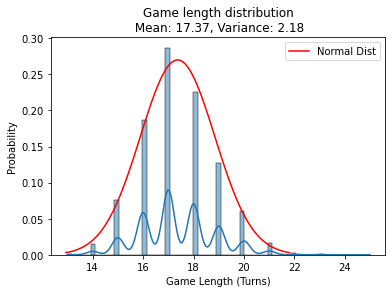

In [48]:
fig = plt.axes()
data = game_df['Turns']
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
normal_dist, = plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r', axes=fig)
data_dist = sns.histplot(data=data, stat='probability', kde=True, axes=fig)
fig.legend((normal_dist,), ('Normal Dist',))
fig.set_xlabel('Game Length (Turns)')
fig.set_title(f'Game length distribution\n Mean: {mu:.2f}, Variance: {sigma**2:.2f}')
plt.show()

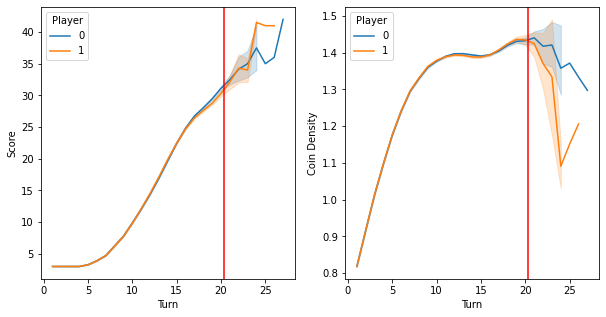

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex='all')
sns.lineplot(x='Turn', y='Score', data=df, hue='Player', ax=axes[0])
sns.lineplot(x='Turn', y='Density', data=df, hue='Player', ax=axes[1])
axes[1].set_ylabel('Coin Density')
axes[0].axvline(x=2 * sigma + mu, c='r')
axes[1].axvline(x=2 * sigma + mu, c='r')

Red line is two standard deviations above average game length. Some interesting tail behavior but otherwise looks pretty normal. Greening starts at around turn 6-8 when score starts increasing and coin density starts increasing slower. 

In [57]:
n_total = len(non_utail_idxs)
n_ties = len(non_utail_idxs.intersection(tie_idxs))
n_wins = len(non_utail_idxs.intersection(p_win_idxs))

print(f'P(Win) = {(n_wins / n_total) * 100:.2f}%')
print(f'P(Loss) = {(n_total - n_wins - n_ties) / n_total * 100:.2f}%')
print(f'P(Tie) = {n_ties / n_total * 100:.2f}%\n')

print(f'Starting player gets extra turn (i.e. ends game) {n_extra_turn / n * 100}% of the time.')

non_utail_neq_turns_idxs = non_utail_idxs.intersection(neq_turn_idxs)
n_extra_turn = len(non_utail_neq_turns_idxs)
p0_win_given_extra_turn = len(non_utail_neq_turns_idxs.intersection(p_win_idxs))
p0_loss_given_extra_turn = len(non_utail_neq_turns_idxs.intersection(p_loss_idxs))
p0_tie_given_extra_turn = len(non_utail_neq_turns_idxs.intersection(tie_idxs))
print(f'P(Wins | Extra Turn) = {p0_win_given_extra_turn / n_extra_turn * 100:.2f}%')
print(f'P(Loses | Extra Turn) = {p0_loss_given_extra_turn / n_extra_turn * 100:.2f}%')
print(f'P(Ties | Extra Turn) = {p0_tie_given_extra_turn / n_extra_turn * 100:.2f}%')

print('')
non_utail_eq_turns_idxs = non_utail_idxs.intersection(eq_turn_idxs)
n_eq_turn = len(non_utail_eq_turns_idxs)
p0_win_equal_turn = len(non_utail_eq_turns_idxs.intersection(p_win_idxs))
p0_loss_equal_turn = len(non_utail_eq_turns_idxs.intersection(p_loss_idxs))
p0_tie_equal_turn = len(non_utail_eq_turns_idxs.intersection(tie_idxs))
print(f'P(Wins | Equal Turn) = {p0_win_equal_turn / n_eq_turn * 100:.2f}%')
print(f'P(Loses | Equal Turn) = {p0_loss_equal_turn / n_eq_turn * 100:.2f}%')
print(f'P(Ties | Equal Turn) = {p0_tie_equal_turn / n_eq_turn * 100:.2f}%')

P(Win) = 43.38%
P(Loss) = 30.88%
P(Tie) = 25.74%

Starting player gets extra turn (i.e. ends game) 50.49% of the time.
P(Wins | Extra Turn) = 57.08%
P(Loses | Extra Turn) = 20.30%
P(Ties | Extra Turn) = 22.62%

P(Wins | Equal Turn) = 28.78%
P(Loses | Equal Turn) = 42.15%
P(Ties | Equal Turn) = 29.07%


Probabilities are basically the same after removing upper tail (super long games), so phenomenon is not due to tail effects.  
P(Win) = 43.64%  
P(Loss) = 30.91%  
P(Tie) = 25.45%  
  
Starting player gets extra turn (i.e. ends game) 51.99% of the time.  
P(Wins | Extra Turn) = 57.36%  
P(Loses | Extra Turn) = 20.35%  
P(Ties | Extra Turn) = 22.29%  
  
P(Wins | Equal Turn) = 28.79%  
P(Loses | Equal Turn) = 42.35%  
P(Ties | Equal Turn) = 28.87%

In 10k games between BM BM, we have 43.34%/32.12%/24.54% WLT split for random starting split. 43.36%/31.96%/24.68% for 2/5 split. 42.85%/32.18%/24.97% for 3/4 split. Corresponds to starting advantage of 11.22%, 11.4%, 10.67%, resp. 

* Why is the starting advantage 10%? 
* Why does 2/5 not have as large an advantage as 3/4? 

In [67]:
p0firstprovinceturn = p0_df.set_index(['Iter', 'Turn']).loc[first_card_idxs(0, 'Province')].reset_index()['Turn']
p1firstprovinceturn = p1_df.set_index(['Iter', 'Turn']).loc[first_card_idxs(1, 'Province')].reset_index()['Turn']
firstprovinceturndiff = p0firstprovinceturn - p1firstprovinceturn

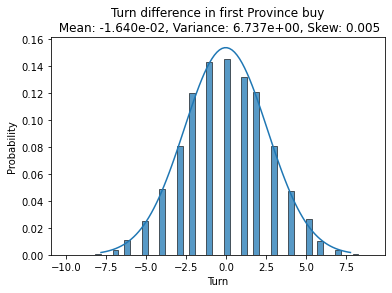

In [69]:
fig = plt.axes()
data = firstprovinceturndiff
mu = data.mean()
sigma = data.std() 
skew = data.skew()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), axes=fig)
sns.histplot(data=data, ax=fig, stat='probability')
fig.set_title(f'Turn difference in first Province buy\n Mean: {mu:.3e}, Variance: {sigma**2:.3e}, Skew: {skew:.3f}')
plt.show()

From above, we see that the difference in turn between first Province buy is basically normal with zero mean, so both players buy first Province at basically the same time, so there is no advantage at this point. 

In [70]:
p0_penult_df = p0_df.set_index(['Iter', 'Turn']).loc[penult_turn_idxs]
p1_penult_df = p1_df.set_index(['Iter', 'Turn']).loc[penult_turn_idxs]

In [71]:
p0_win_penult = (p0_penult_df['Score'] > p1_penult_df['Score']).sum().item()
p0_loss_penult = (p0_penult_df['Score'] < p1_penult_df['Score']).sum().item()
p0_tie_penult = (p0_penult_df['Score'] == p1_penult_df['Score']).sum().item()

print(f'P(Winning at penult) = {p0_win_penult / n * 100:.2f}%')
print(f'P(Losing at penult) = {p0_loss_penult / n * 100:.2f}%')
print(f'P(Tied at penult) = {p0_tie_penult / n * 100:.2f}%')

P(Winning at penult) = 43.81%
P(Losing at penult) = 44.30%
P(Tied at penult) = 11.89%


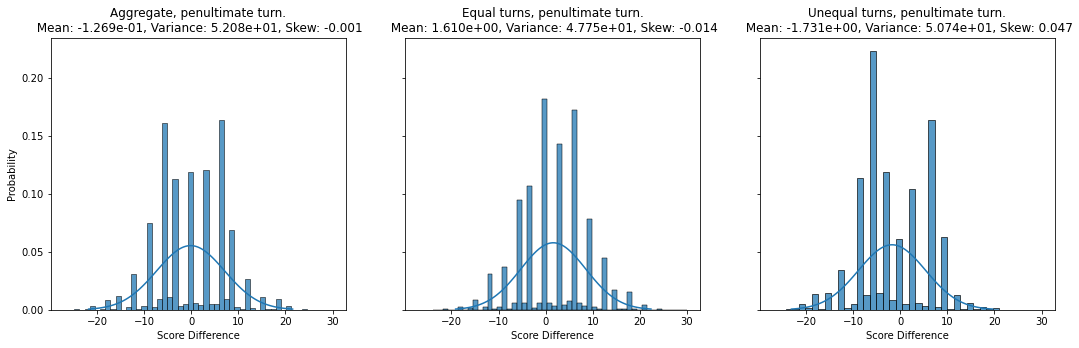

In [78]:
penult_score_diff = p0_penult_df['Score'] - p1_penult_df['Score']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex='all', sharey='all')
data = penult_score_diff
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma))
sns.histplot(x=data, ax=axes[0], stat='probability')
axes[0].set_xlabel('Score Difference')
axes[0].set_title(f'Aggregate, penultimate turn.\n Mean: {mu:.3e}, Variance: {sigma**2:.3e}, Skew: {skew:.3f}')

eq_turn_penult_score_diff = p0_penult_df.loc[eq_turn_idxs]['Score'] - p1_penult_df.loc[eq_turn_idxs]['Score']

data = eq_turn_penult_score_diff
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma))
sns.histplot(x=data, ax=axes[1], stat='probability')
axes[1].set_xlabel('Score Difference')
axes[1].set_title(f'Equal turns, penultimate turn.\n Mean: {mu:.3e}, Variance: {sigma**2:.3e}, Skew: {skew:.3f}')

neq_turn_penult_score_diff = p0_penult_df.loc[neq_turn_idxs]['Score'] - p1_penult_df.loc[neq_turn_idxs]['Score']

data = neq_turn_penult_score_diff
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axes[2].plot(x, stats.norm.pdf(x, mu, sigma))
sns.histplot(x=data, ax=axes[2], stat='probability')
axes[2].set_xlabel('Score Difference')
axes[2].set_title(f'Unequal turns, penultimate turn.\n Mean: {mu:.3e}, Variance: {sigma**2:.3e}, Skew: {skew:.3f}')
plt.show()

Distribution of scores at the penultimate turn is not normal, but is approximately zero-centered and symmetric. However, starting player is much more likely to be up an Estate. 

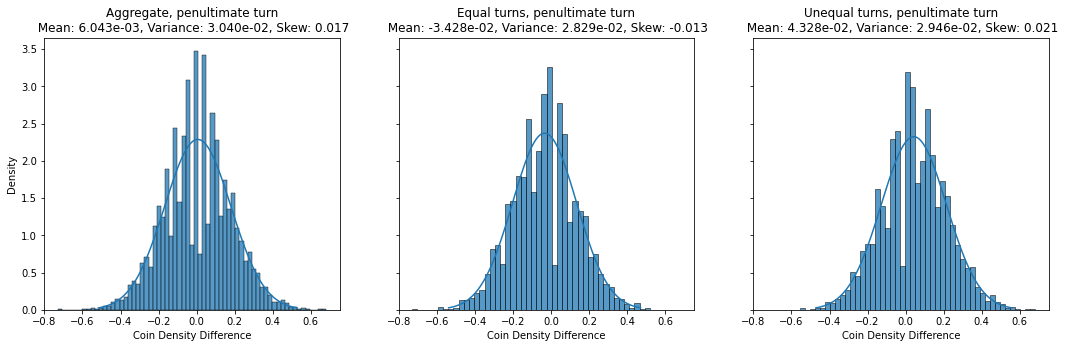

In [79]:
penult_coin_density_diff = p0_penult_df['Density'] - p1_penult_df['Density']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex='all', sharey='all')
data = penult_coin_density_diff
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma))
sns.histplot(x=data, ax=axes[0], stat='density')
axes[0].set_xlabel('Coin Density Difference')
axes[0].set_title(f'Aggregate, penultimate turn\n Mean: {mu:.3e}, Variance: {sigma**2:.3e}, Skew: {skew:.3f}')

eq_turn_penult_density_diff = p0_penult_df.loc[eq_turn_idxs]['Density'] - p1_penult_df.loc[eq_turn_idxs]['Density']

data = eq_turn_penult_density_diff
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma))
sns.histplot(x=data, ax=axes[1], stat='density')
axes[1].set_xlabel('Coin Density Difference')
axes[1].set_title(f'Equal turns, penultimate turn\n Mean: {mu:.3e}, Variance: {sigma**2:.3e}, Skew: {skew:.3f}')

neq_turn_penult_coin_diff = p0_penult_df.loc[neq_turn_idxs]['Density'] - p1_penult_df.loc[neq_turn_idxs]['Density']

data = neq_turn_penult_coin_diff
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axes[2].plot(x, stats.norm.pdf(x, mu, sigma))
sns.histplot(x=data, ax=axes[2], stat='density')
axes[2].set_xlabel('Coin Density Difference')
axes[2].set_title(f'Unequal turns, penultimate turn\n Mean: {mu:.3e}, Variance: {sigma**2:.3e}, Skew: {skew:.3f}')
plt.show()

Again, the coin density is approximately zero-mean normal at the penultimate turn. However, when the first player gets a starting turn, they tend to have a slight coin density advantage at the penultimate turn. The opposite is true when both players get equal turns.

In [84]:
eq_turns_df = df.set_index(['Iter']).loc[eq_turn_idxs]
neq_turns_df = df.set_index(['Iter']).loc[neq_turn_idxs]
eq_turns = eq_turns_df.reset_index()[['Iter', 'Turn']].groupby('Iter').max()
neq_turns = neq_turns_df.reset_index()[['Iter', 'Turn']].groupby('Iter').max()

In [85]:
mu_eq_turns = eq_turns.mean().item()
sigma_eq_turns = eq_turns.std().item()
mu_neq_turns = neq_turns.mean().item()
sigma_neq_turns = neq_turns.std().item()

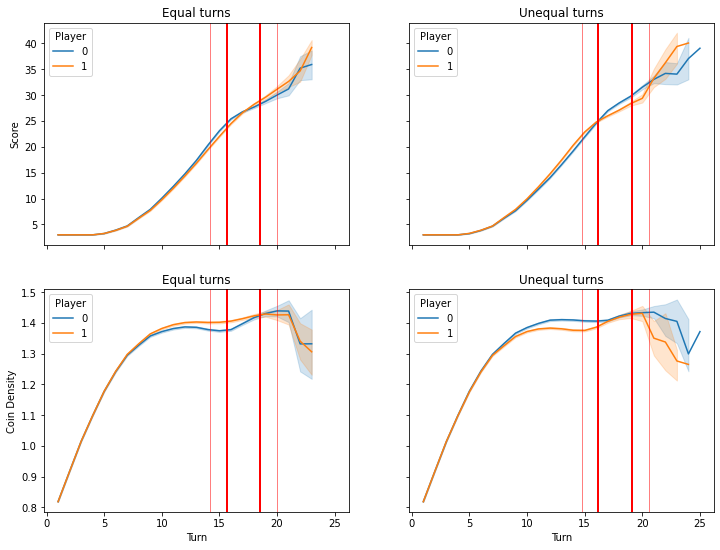

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex='all', sharey='row')

sns.lineplot(x='Turn', y='Score', data=eq_turns_df, ax=axes[0, 0], hue='Player')
axes[0, 0].set_title('Equal turns')
axes[0, 0].axvline(x=mu_eq_turns + sigma_eq_turns, c='r', linewidth=2)
axes[0, 0].axvline(x=mu_eq_turns - sigma_eq_turns, c='r', linewidth=2)
axes[0, 0].axvline(x=mu_eq_turns + 2 * sigma_eq_turns, c='r', linewidth=0.5)
axes[0, 0].axvline(x=mu_eq_turns - 2 * sigma_eq_turns, c='r', linewidth=0.5)

sns.lineplot(x='Turn', y='Score', data=neq_turns_df, ax=axes[0, 1], hue='Player')
axes[0, 1].set_title('Unequal turns')
axes[0, 1].axvline(x=mu_neq_turns + sigma_neq_turns, c='r', linewidth=2)
axes[0, 1].axvline(x=mu_neq_turns - sigma_neq_turns, c='r', linewidth=2)
axes[0, 1].axvline(x=mu_neq_turns + 2 * sigma_neq_turns, c='r', linewidth=0.5)
axes[0, 1].axvline(x=mu_neq_turns - 2 * sigma_neq_turns, c='r', linewidth=0.5)

sns.lineplot(x='Turn', y='Density', data=eq_turns_df, ax=axes[1, 0], hue='Player')
axes[1, 0].set_title('Equal turns')
axes[1, 0].set_ylabel('Coin Density')
axes[1, 0].axvline(x=mu_eq_turns + sigma_eq_turns, c='r', linewidth=2)
axes[1, 0].axvline(x=mu_eq_turns - sigma_eq_turns, c='r', linewidth=2)
axes[1, 0].axvline(x=mu_eq_turns + 2 * sigma_eq_turns, c='r', linewidth=0.5)
axes[1, 0].axvline(x=mu_eq_turns - 2 * sigma_eq_turns, c='r', linewidth=0.5)

sns.lineplot(x='Turn', y='Density', data=neq_turns_df, ax=axes[1, 1], hue='Player')
axes[1, 1].set_title('Unequal turns')
axes[1, 1].set_ylabel('Coin Density')
axes[1, 1].axvline(x=mu_neq_turns + sigma_neq_turns, c='r', linewidth=2)
axes[1, 1].axvline(x=mu_neq_turns - sigma_neq_turns, c='r', linewidth=2)
axes[1, 1].axvline(x=mu_neq_turns + 2 * sigma_neq_turns, c='r', linewidth=0.5)
axes[1, 1].axvline(x=mu_neq_turns - 2 * sigma_neq_turns, c='r', linewidth=0.5)

plt.show()

Thicker red line is 2 std; thinner is 1 std. We see that the player that ends the game (and who is more likely to win), seems to green slightly later and have a significant money density advantage right before greening. Let's take a look at first Gold turn split by outcome. 

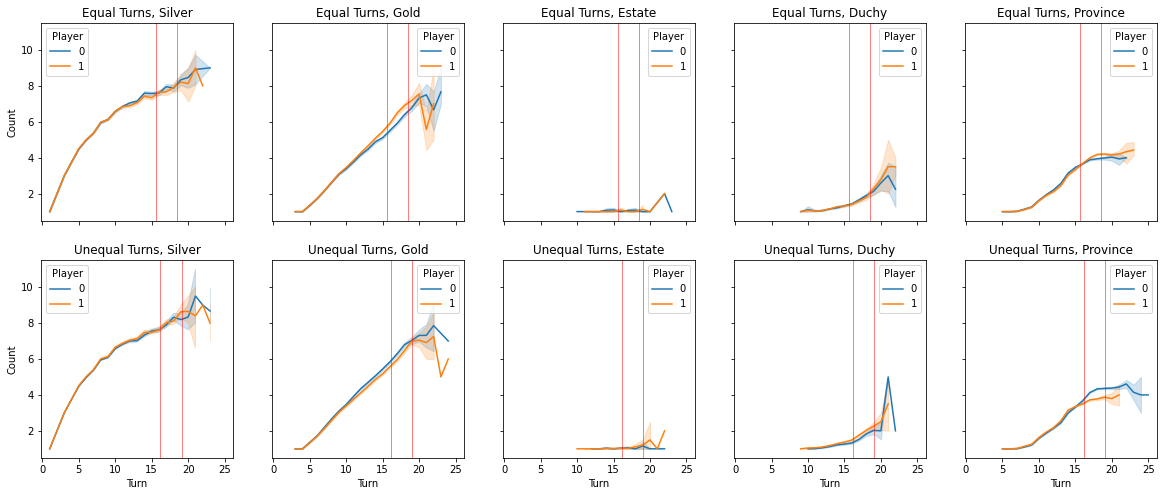

In [91]:
cards = ['Silver', 'Gold', 'Estate', 'Duchy', 'Province']
fig, axes = plt.subplots(2, len(cards), figsize=(20, 8), sharex='all', sharey='all')

eq_temp = df.set_index('Iter').loc[eq_turn_idxs]
neq_temp = df.set_index('Iter').loc[neq_turn_idxs]

for i, card in enumerate(cards):
    eq_select = eq_temp[eq_temp['Card'] == card]    
    neq_select = neq_temp[neq_temp['Card'] == card]

    sns.lineplot(x='Turn', y='Count', data=eq_select, hue='Player', ax=axes[0, i])
    axes[0, i].set_title(f'Equal Turns, {card}')
    axes[0, i].axvline(x=mu_eq_turns + sigma_eq_turns, c='r', linewidth=0.5)
    axes[0, i].axvline(x=mu_eq_turns - sigma_eq_turns, c='r', linewidth=0.5)
    sns.lineplot(x='Turn', y='Count', data=neq_select, hue='Player', ax=axes[1, i])    
    axes[1, i].set_title(f'Unequal Turns, {card}')
    axes[1, i].axvline(x=mu_neq_turns + sigma_neq_turns, c='r', linewidth=0.5)
    axes[1, i].axvline(x=mu_neq_turns - sigma_neq_turns, c='r', linewidth=0.5)

In [98]:
card = 'Province'
p0_first_card_turn = p0_df.set_index(['Iter', 'Turn']).loc[first_card_idxs(0, card)].reset_index()['Turn']
p1_first_card_turn = p1_df.set_index(['Iter', 'Turn']).loc[first_card_idxs(1, card)].reset_index()['Turn']
first_card_turn_diff = p0_first_card_turn - p1_first_card_turn

p0_eq_turns_first_card_turn = p0_first_card_turn.loc[eq_turn_idxs]
p1_eq_turns_first_card_turn = p1_first_card_turn.loc[eq_turn_idxs]
first_card_turn_diff_eq = p0_eq_turns_first_card_turn - p1_eq_turns_first_card_turn

p0_neq_turns_first_card_turn = p0_first_card_turn.loc[neq_turn_idxs]
p1_neq_turns_first_card_turn = p1_first_card_turn.loc[neq_turn_idxs]
first_card_turn_diff_neq = p0_neq_turns_first_card_turn - p1_neq_turns_first_card_turn

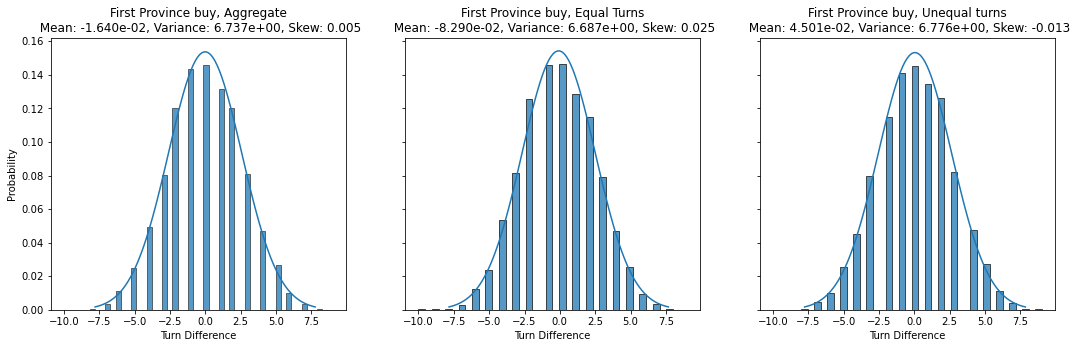

In [101]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex='all', sharey='all')

data = first_card_turn_diff
mu = data.mean()
sigma = data.std() 
skew = data.skew()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma))
sns.histplot(data=data, ax=axes[0], stat='probability')
axes[0].set_xlabel('Turn Difference')
axes[0].set_title(f'First {card} buy, Aggregate\n Mean: {mu:.3e}, Variance: {sigma**2:.3e}, Skew: {skew:.3f}')

data = first_card_turn_diff_eq
mu = data.mean()
sigma = data.std() 
skew = data.skew()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma))
sns.histplot(data=data, ax=axes[1], stat='probability')
axes[1].set_xlabel('Turn Difference')
axes[1].set_title(f'First {card} buy, Equal Turns\n Mean: {mu:.3e}, Variance: {sigma**2:.3e}, Skew: {skew:.3f}')

data = first_card_turn_diff_neq
mu = data.mean()
sigma = data.std() 
skew = data.skew()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axes[2].plot(x, stats.norm.pdf(x, mu, sigma))
sns.histplot(data=data, ax=axes[2], stat='probability')
axes[2].set_xlabel('Turn Difference')
axes[2].set_title(f'First {card} buy, Unequal turns\n Mean: {mu:.3e}, Variance: {sigma**2:.3e}, Skew: {skew:.3f}')

plt.show()

## MLP Simulations ##

In [4]:
model_name = 'r-r-mcts-10k-score'
model_path = os.path.join(model_dir, model_name)
model = torch.load(model_path, map_location='cpu')
model

In [114]:
config = GameConfig(split=StartingSplit.StartingRandomSplit, sandbox=True, num_players=2)
players = load_players(['MLP', 'BM'], [model_path], map_location='cpu', train=False)
agent = players[0]
env = DefaultEnvironment(config, players, logger=logger)

In [117]:
simulate(env, 1, None)

  0%|          | 0/1 [00:00<?, ?it/s]BUY:root:Player 0, Turn 0: Estate
BUY:root:Player 1, Turn 1: Silver
BUY:root:Player 0, Turn 1: Estate
BUY:root:Player 1, Turn 2: Silver
BUY:root:Player 0, Turn 2: Estate
BUY:root:Player 1, Turn 3: Gold
BUY:root:Player 0, Turn 3: Estate
BUY:root:Player 1, Turn 4: Silver
BUY:root:Player 0, Turn 4: Estate
BUY:root:Player 1, Turn 5: Silver
BUY:root:Player 0, Turn 5: None
BUY:root:Player 1, Turn 6: Gold
BUY:root:Player 0, Turn 6: Estate
BUY:root:Player 1, Turn 7: Gold
BUY:root:Player 0, Turn 7: Copper
BUY:root:Player 1, Turn 8: Gold
BUY:root:Player 0, Turn 8: Estate
BUY:root:Player 1, Turn 9: Silver
BUY:root:Player 0, Turn 9: Estate
BUY:root:Player 1, Turn 10: Silver
BUY:root:Player 0, Turn 10: Copper
BUY:root:Player 1, Turn 11: Province
BUY:root:Player 0, Turn 11: Copper
BUY:root:Player 1, Turn 12: Gold
BUY:root:Player 0, Turn 12: Silver
BUY:root:Player 1, Turn 13: Province
BUY:root:Player 0, Turn 13: Copper
BUY:root:Player 1, Turn 14: Gold
BUY:root:Pla

Let's analyze the neural network outputs for some simple cases.

In [20]:
from state import ReducedStateFeature

In [21]:
skip = ReducedStateFeature.default_sandbox_feature()
copper = ReducedStateFeature.default_sandbox_feature()
silver = ReducedStateFeature.default_sandbox_feature()
estate = ReducedStateFeature.default_sandbox_feature()

In [22]:
copper[0] = 45
copper[7] = 8
copper

tensor([45., 10.,  8.,  8.,  8., 40., 30.,  8.,  0.,  3.,  0.,  0.,  0.,  0.,
         7.,  0.,  3.,  0.,  0.,  0.,  0.])

In [23]:
silver[5] = 39
silver[7+5] = 1
silver

tensor([46., 10.,  8.,  8.,  8., 39., 30.,  7.,  0.,  3.,  0.,  0.,  1.,  0.,
         7.,  0.,  3.,  0.,  0.,  0.,  0.])

In [24]:
estate[2] = 7
estate[7+2] = 4
estate

tensor([46., 10.,  7.,  8.,  8., 40., 30.,  7.,  0.,  4.,  0.,  0.,  0.,  0.,
         7.,  0.,  3.,  0.,  0.,  0.,  0.])

In [54]:
agent.model(copper), agent.model(silver), agent.model(estate)

TypeError: 'LogisticRegression' object is not callable

## Tree Simulations ##

In [5]:
from mcts import GameTree

In [22]:
tree_name = 'default-r-r-mcts'
tree_path = os.path.join(model_dir, tree_name)
rollout_name = 'default-mlog'
rollout_path = os.path.join(model_dir, rollout_name)

In [10]:
tree_name = 'r-r-mcts-bm-100k-srat-base-default-ucb1-cdecay'
rollout_name = 'mlog-10k-base-default-bm'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [11]:
tree = GameTree.load(tree_path, train=False, _skip_level=False, selection='max')

In [42]:
tree.selection = 'secure'
tree.selection

'secure'

In [121]:
tree._root.children[2].children[6].children[14]

Parent: Militia << (n: 1877, v: 1269.0, Q: 0.676 c: Witch) >> Children: [(0, 'Copper', '141', '0.177'), (1, 'Estate', '80', '0.025'), (2, 'Silver', '310', '0.329'), (3, 'Chapel', '503', '0.397'), (4, 'Moat', '538', '0.404'), (5, 'Village', '143', '0.199'), (6, 'None', '161', '0.208')]

In [12]:
# config = GameConfig(splits=[StartingSplit.Starting25Split, StartingSplit.Starting25Split], sandbox=True, num_players=2)
# splits = [StartingSplit.Starting25Split, StartingSplit.Starting25Split]
splits = [StartingSplit.StartingRandomSplit, StartingSplit.StartingRandomSplit]
config = GameConfig(splits=splits, sandbox=False, num_players=2, must_include=default_kingdom)
players = load_players(['UCT', 'DW'], [rollout_path], tree=tree, train=False, rollout_type='mlog', use_tree=True)
# agent = load_players(['UCT'], [rollout_path], tree=tree, train=False, rollout_type='mlog', use_tree=False)[0]
# players = [agent, agent]
env = DefaultEnvironment(config, players, logger=logger)

In [21]:
logger.setLevel(logging.ERROR)
# logger.setLevel(BUY)

In [23]:
sim_data = simulate(env, 1000, tree)

100%|██████████| 1000/1000 [00:24<00:00, 40.35it/s]===SUMMARY===
{0: 593, 1: 437, 'ProvinceWins': 994, 'Ties': 30}



In [12]:
sim_data.game_df

,MaxScore,ProvinceWin,TimeElapsed,Tie
0,40.0,True,0.06635,False


In [97]:
data_dir = os.path.join(project_root, 'data')
data_name ='bm25-bm25-10k-scores'
data_path = os.path.join(data_dir, data_name)

In [98]:
save(data_path, sim_data.player_df)